In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [9]:
import taichi as ti
ti.init(arch=ti.cpu)

[Taichi] Starting on arch=arm64


In [13]:
# Параметры системы
# N = 50  # Число осцилляторов по горизонтали
# M = 50  # Число осцилляторов по вертикали
m = 0.1  # Масса каждого осциллятора
g = 9.8  # Ускорение свободного падения
dt = 0.01  # Шаг времени
nstep = 30  # Количество шагов

# Параметры связей
# l0 = 1/(n-1)  # Длина нерастяжимой связи
Cs = 500.0  # Жесткость при контакте со сферой
Bs = 5.0  # Коэффициент демпфирования при контакте со сферой
R = 0.25  # Радиус сферы
sphere_center = ti.Vector([1.0, 1.0, 1.0])  # Центр сферы


In [54]:
# N = [10,25,50,75,100,150,200]
# M = [10,25,50,75,100,150,200]

In [99]:
# Начальные условия
def compute_cpu_memory(n,m,cpu_max_num_threads,memory_layout):
    N = n * m
    
    ti.init(arch=ti.cpu, cpu_max_num_threads=cpu_max_num_threads)

    if memory_layout == "dense":
        # Плотные массивы
        x = ti.Vector.field(3, ti.f32, shape=(n, m))
        v = ti.Vector.field(3, ti.f32, shape=(n, m))
        a = ti.Vector.field(3, ti.f32, shape=(n, m))
        forces = ti.Vector.field(3, ti.f32, shape=(n, m))
        x_prev = ti.Vector.field(3, ti.f32, shape=(n, m))
    elif memory_layout == "pointerdense":
        x = ti.Vector.field(3, dtype=ti.f32)
        v = ti.Vector.field(3, dtype=ti.f32)
        a = ti.Vector.field(3, dtype=ti.f32)
        forces = ti.Vector.field(3, dtype=ti.f32)
        x_prev = ti.Vector.field(3, dtype=ti.f32)
        # ti.root.dense(ti.i, n).pointer(ti.j, m).place(x)
        # ti.root.dense(ti.i, n).pointer(ti.j, m).place(v)
        # ti.root.dense(ti.i, n).pointer(ti.j, m).place(a)
        # ti.root.dense(ti.i, n).pointer(ti.j, m).place(forces)
        # ti.root.dense(ti.i, n).pointer(ti.j, m).place(x_prev)
        ti.root.pointer(ti.i, n).dense(ti.j, m).place(x,v,a,forces, x_prev)
    elif memory_layout == "pointer":
        x = ti.Vector.field(3, dtype=ti.f32)
        v = ti.Vector.field(3, dtype=ti.f32)
        a = ti.Vector.field(3, dtype=ti.f32)
        forces = ti.Vector.field(3, dtype=ti.f32)
        x_prev = ti.Vector.field(3, dtype=ti.f32)
        ti.root.pointer(ti.i, n).dense(ti.j, m).place(x)
        ti.root.pointer(ti.i, n).dense(ti.j, m).place(v)
        ti.root.pointer(ti.i, n).dense(ti.j, m).place(a)
        ti.root.pointer(ti.i, n).dense(ti.j, m).place(forces)
        ti.root.pointer(ti.i, n).dense(ti.j, m).place(x_prev)
        
    l0 = 1/(n-1) 
    
    
    # Расположение осцилляторов в начальный момент
    @ti.kernel
    def init_x_v():
        for i in range(n):
            for j in range(m):
                x[i, j] = [i * l0 + 0.5, j * l0 + 0.5, 1.5]  # Начальная высота 1.5
                v[i, j] = [0, 0, 0]
                a[i, j] = [0, 0, 0]
                # Предыдущие положения для метода Верле
                x_prev[i, j] = x[i, j] - v[i, j] * dt + 0.5 * a[i, j] * dt**2
    
    init_x_v()  
    # print(x.to_numpy())

    # Функция для расчета сил
    @ti.kernel
    def compute_forces():
        # Гравитация
        for i in range(n):
            for j in range(m):
                forces[i, j] = [0, 0, - m * g]
        # Взаимодействие со сферой
        for i in range(m):
            for j in range(m):
                r = x[i, j] - sphere_center
                # dist = np.linalg.norm(r)
                dist = ti.sqrt(r.x ** 2 + r.y ** 2 + r.z ** 2)
                if dist < R:  # Если масса внутри сферы
                    normal = r / dist  # Нормаль к поверхности сферы
                    penetration = R - dist  # Глубина проникновения
                    # relative_velocity = np.dot(v[i, j], normal)  # Проекция скорости на нормаль
                    relative_velocity = v[i, j] * normal
                    # Добавляем силу отталкивания и демпфирования
                    forces[i, j] += Cs * penetration * normal + Bs * relative_velocity * normal
                    # Корректируем положение массы на поверхности сферы
                    for _ in range(5):  # Итеративная коррекция  IPC
                        r = x[i, j] - sphere_center
                        # dist = np.linalg.norm(r)
                        dist = ti.sqrt(r.x ** 2 + r.y ** 2 + r.z ** 2)
                        if dist < R:
                            normal = r / dist
                            penetration = R - dist
                            x[i, j] += penetration * normal
                    # Разделяем скорость на нормальную и тангенциальную составляющие
                    normal = r / dist
                    # v_normal = np.dot(v[i, j], normal) * normal
                    v_normal = v[i, j].dot(normal) * normal
                    v_tangent = v[i, j] - v_normal
                    v[i, j] = v_tangent  # Сохраняем только тангенциальную составляющую
                    # Проверка, что масса на поверхности
                    # assert np.isclose(np.linalg.norm(x[i, j] - sphere_center), R), \
                    #     f"Ошибка: масса не на поверхности сферы, dist={np.linalg.norm(x[i, j] - sphere_center)}"
        # return forces
        
    # Проекционный метод для восстановления нерастяжимых связей。
    #PD 将约束位置（例如布料长度，碰撞约束）转化为几何方程，通过求解（通常迭代Gauss/Jacobi）调整顶点位置，确保约束满足
    @ti.kernel
    def enforce_constraints():
        tolerance = 1e-6  # Допустимая погрешность
        max_iterations = 100  # Максимальное число итераций
        for _ in range(max_iterations):
            max_error = 0.0
            for i in range(n):
                for j in range(m):
                    forces[i, j] = [0, 0, - m * g]
                    # Коррекция связей с соседями
                    if i < n - 1:  # Горизонтальная связь 
                        dx = x[i + 1, j] - x[i, j]
                        dist = ti.sqrt(dx.x ** 2 + dx.y ** 2 + dx.z ** 2)
                        error = abs(dist - l0)
                        max_error = max(max_error, error)
                        correction = (l0 - dist) / (2 * dist) * dx
                        x[i + 1, j] += correction
                        x[i, j] -= correction
                    if j < m - 1:  # Вертикальная связь
                        dy = x[i, j + 1] - x[i, j]
                        # dist = np.linalg.norm(dy)
                        dist = ti.sqrt(dy.x ** 2 + dy.y ** 2 + dy.z ** 2)
                        error = abs(dist - l0)
                        max_error = max(max_error, error)
                        correction = (l0 - dist) / (2 * dist) * dy
                        x[i, j + 1] += correction
                        x[i, j] -= correction
            # if max_error < tolerance:
            #     break
            
    
                
    @ti.kernel
    def update_x_v():
        for i in range(n):
            for j in range(m):
                forces[i, j] = [0, 0, - m * g]
                a[i, j] = forces[i, j] / m  # Вычисляем ускорения
                # Метод Верле
                x_next = 2 * x[i, j] - x_prev[i, j] + a[i, j] * dt**2
                v_new = (x_next - x_prev[i, j]) / (2 * dt)
                x_prev[i, j] = x[i, j]
                x[i, j] = x_next
                v[i, j] = v_new
            
    
    # Создание каталога для сохранения кадров
    # output_dir = f"frames_{n}*{m}_taichi"
    # os.makedirs(output_dir, exist_ok=True)
    
    import time
    # Моделирование
    positions = []
    start_time = time.time()
    for step in range(nstep):
        # print(f"STEP: {step}")
        compute_forces()  # Рассчитываем силы
        update_x_v()
        # Применяем проекционный метод
        enforce_constraints()
        positions.append(x.to_numpy().copy())
        # print(f"X {x.to_numpy()}")
        # Визуализация
        # visualize_step(x.to_numpy(), step)
    end_time = time.time()
            
    # print(f"Моделирование завершено. Кадры сохранены в каталог '{output_dir}'.")
    return end_time - start_time
                
    

In [16]:
# # Функция для визуализации текущего состояния
# def visualize_step(x, step):
#     xs, ys, zs = x[:, :, 0], x[:, :, 1], x[:, :, 2]
#     fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Четыре панели (2x2)
#     # Общий трехмерный вид
#     ax_general = fig.add_subplot(2, 2, 1, projection='3d')
#     ax_general.scatter(xs, ys, zs, c='blue', s=50, label='Массы')
#     # Отображение связей
#     for i in range(N):
#         for j in range(M):
#             if i < N - 1:  # Горизонтальные связи
#                 ax_general.plot([x[i, j, 0], x[i + 1, j, 0]],
#                                 [x[i, j, 1], x[i + 1, j, 1]],
#                                 [x[i, j, 2], x[i + 1, j, 2]], color='gray', linewidth=0.5)
#             if j < M - 1:  # Вертикальные связи
#                 ax_general.plot([x[i, j, 0], x[i, j + 1, 0]],
#                                 [x[i, j, 1], x[i, j + 1, 1]],
#                                 [x[i, j, 2], x[i, j + 1, 2]], color='gray', linewidth=0.5)
#     # Отображение сферы
#     u = np.linspace(0, 2 * np.pi, 100)
#     v = np.linspace(0, np.pi, 50)
#     x_sphere = sphere_center[0] + R * np.outer(np.cos(u), np.sin(v))
#     y_sphere = sphere_center[1] + R * np.outer(np.sin(u), np.sin(v))
#     z_sphere = sphere_center[2] + R * np.outer(np.ones(np.size(u)), np.cos(v))
#     ax_general.plot_surface(x_sphere, y_sphere, z_sphere, color='red', alpha=0.5, label='Сфера')
#     # Настройка графика
#     ax_general.set_xlim(-0.1, 2.0)
#     ax_general.set_ylim(-0.1, 2.0)
#     ax_general.set_zlim(-0.1, 2.0)
#     ax_general.set_box_aspect([1, 1, 1])
#     ax_general.set_xlabel('X')
#     ax_general.set_ylabel('Y')
#     ax_general.set_zlabel('Z')
#     ax_general.set_title("Общий вид")
#     ax_general.legend()
#     # Вид сверху вдоль оси Z
#     ax_top = fig.add_subplot(2, 2, 2)
#     ax_top.scatter(xs, ys, c='blue', s=50, label='Массы')
#     for i in range(N):
#         for j in range(M):
#             if i < N - 1:  # Горизонтальные связи
#                 ax_top.plot([x[i, j, 0], x[i + 1, j, 0]],
#                             [x[i, j, 1], x[i + 1, j, 1]], color='gray', linewidth=0.5)
#             if j < M - 1:  # Вертикальные связи
#                 ax_top.plot([x[i, j, 0], x[i, j + 1, 0]],
#                             [x[i, j, 1], x[i, j + 1, 1]], color='gray', linewidth=0.5)
#     ax_top.set_xlim(-0.1, 2.0)
#     ax_top.set_ylim(-0.1, 2.0)
#     ax_top.set_xlabel('X')
#     ax_top.set_ylabel('Y')
#     ax_top.set_title("Вид сверху (по Z)")
#     ax_top.legend()
#     # Вид сбоку вдоль оси X
#     ax_side_x = fig.add_subplot(2, 2, 3)
#     ax_side_x.scatter(ys, zs, c='blue', s=50, label='Массы')
#     for i in range(N):
#         for j in range(M):
#             if i < N - 1:  # Горизонтальные связи
#                 ax_side_x.plot([x[i, j, 1], x[i + 1, j, 1]],
#                                [x[i, j, 2], x[i + 1, j, 2]], color='gray', linewidth=0.5)
#             if j < M - 1:  # Вертикальные связи
#                 ax_side_x.plot([x[i, j, 1], x[i, j + 1, 1]],
#                                [x[i, j, 2], x[i, j + 1, 2]], color='gray', linewidth=0.5)
#     ax_side_x.set_xlim(-0.1, 2.0)
#     ax_side_x.set_ylim(-0.1, 2.0)
#     ax_side_x.set_xlabel('Y')
#     ax_side_x.set_ylabel('Z')
#     ax_side_x.set_title("Вид сбоку (по X)")
#     ax_side_x.legend()
#     # Вид сбоку вдоль оси Y
#     ax_side_y = fig.add_subplot(2, 2, 4)
#     ax_side_y.scatter(xs, zs, c='blue', s=50, label='Массы')
#     for i in range(N):
#         for j in range(M):
#             if i < N - 1:  # Горизонтальные связи
#                 ax_side_y.plot([x[i, j, 0], x[i + 1, j, 0]],
#                                [x[i, j, 2], x[i + 1, j, 2]], color='gray', linewidth=0.5)
#             if j < M - 1:  # Вертикальные связи
#                 ax_side_y.plot([x[i, j, 0], x[i, j + 1, 0]],
#                                [x[i, j, 2], x[i, j + 1, 2]], color='gray', linewidth=0.5)
#     ax_side_y.set_xlim(-0.1, 2.0)
#     ax_side_y.set_ylim(-0.1, 2.0)
#     ax_side_y.set_xlabel('X')
#     ax_side_y.set_ylabel('Z')
#     ax_side_y.set_title("Вид сбоку (по Y)")
#     ax_side_y.legend()
#     # Сохранение кадра
#     frame_path = os.path.join(output_dir, f"frame_{step:04d}.png")
#     plt.tight_layout()
#     plt.savefig(frame_path)
#     plt.close(fig)

In [60]:
# import imageio.v2 as imageio
# import os
# 
# # Список файлов кадров
# frame_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith(".png")])
# 
# # Создание анимации
# with imageio.get_writer(f"animation{N}_taichi.gif", mode="I", duration=0.05) as writer:
#     for frame_file in frame_files:
#         image = imageio.imread(frame_file)
#         writer.append_data(image)
# 
# print(f"Анимация сохранена как 'animation{N}_taichi.gif'.")

In [100]:
threads_blocks_managment_settings = [
    {"cpu_max_num_threads": 1, "memory_layout": "dense", "label": "Threads=1, Dense"},
    {"cpu_max_num_threads": 1, "memory_layout": "pointerdense", "label": "Threads=1, PointerDense"},
    {"cpu_max_num_threads": 1, "memory_layout": "pointer", "label": "Threads=1, Pointer"},
    {"cpu_max_num_threads": 8, "memory_layout": "dense", "label": "Threads=8, Dense"},
    {"cpu_max_num_threads": 8, "memory_layout": "pointerdense", "label": "Threads=8, PointerDense"},
    {"cpu_max_num_threads": 8, "memory_layout": "pointer", "label": "Threads=8, Pointer"},
    {"cpu_max_num_threads": 16, "memory_layout": "dense", "label": "Threads=16, Dense"},
    {"cpu_max_num_threads": 16, "memory_layout": "pointerdense", "label": "Threads=16, PointerDense"},
    {"cpu_max_num_threads": 16, "memory_layout": "pointer", "label": "Threads=16, Pointer"},
    # {"cpu_max_num_threads": 16, "memory_layout": 64, "label": "Threads=16, Block=64"},
]
# settings = threads_blocks_managment_settings + memory_management_settings
results = {setting["label"]: [] for setting in threads_blocks_managment_settings}
# results["NumPy"] = []
par = [10,25,50,75,100,150,200,250,300,350,450,500,600,700,800,900,1000]
# par = [10,25,50,75,100,150,200,250,300]
# par = [10]
# M = [10,25,50,75,100,150,200]
print(f"{results = }")

for n in par:
    print(f"Testing with {n} * {n} particles")

    # Тестирование Taichi для всех настроек многопоточности
    for setting in threads_blocks_managment_settings:
        print(f"Testing with {setting} threads")
        taichi_time = compute_cpu_memory(
            n,
            n,
            cpu_max_num_threads=setting["cpu_max_num_threads"],
            memory_layout=setting["memory_layout"],
        )
        results[setting["label"]].append(taichi_time)
        print("results", results)

    # # Тестирование Taichi для всех настроек использования памяти
    # for setting in memory_management_settings:
    #     taichi_time = compute_taichi_memory_management(
    #         n,
    #         cpu_max_num_threads=setting["cpu_max_num_threads"],
    #         memory_layout=setting["memory_layout"]
    #     )
    #     results[setting["label"]].append(taichi_time)

# Построение графиков
plt.figure(figsize=(12, 6))

# График времени выполнения
# plt.subplot(1, 2, 1)
for label, times in results.items():
    plt.plot(par, times, label=label, marker='o')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Время выполнения (сек)")
plt.title("Зависимость времени выполнения от числа частиц в массиве")
plt.legend()

# График ускорения относительно NumPy
# plt.subplot(1, 2, 2)
# for label, times in results.items():
#     if label != "NumPy":
#         speedup = [numpy_t / t for numpy_t, t in zip(results["NumPy"], times)]
#         plt.plot(N, speedup, label=label, marker='o')
# plt.xscale("log")
# plt.xlabel("Число частиц в массиве")
# plt.ylabel("Ускорение относительно NumPy)")
# plt.title("Зависимость ускорения от числа частиц в массиве")
# plt.legend()

plt.tight_layout()
plt.show()

results = {'Threads=1, Dense': [], 'Threads=1, PointerDense': [], 'Threads=1, Pointer': [], 'Threads=8, Dense': [], 'Threads=8, PointerDense': [], 'Threads=8, Pointer': [], 'Threads=16, Dense': [], 'Threads=16, PointerDense': [], 'Threads=16, Pointer': []}
Testing with 10 * 10 particles
Testing with {'cpu_max_num_threads': 1, 'memory_layout': 'dense', 'label': 'Threads=1, Dense'} threads
[Taichi] Starting on arch=arm64
results {'Threads=1, Dense': [0.0664210319519043], 'Threads=1, PointerDense': [], 'Threads=1, Pointer': [], 'Threads=8, Dense': [], 'Threads=8, PointerDense': [], 'Threads=8, Pointer': [], 'Threads=16, Dense': [], 'Threads=16, PointerDense': [], 'Threads=16, Pointer': []}
Testing with {'cpu_max_num_threads': 1, 'memory_layout': 'pointerdense', 'label': 'Threads=1, PointerDense'} threads
[Taichi] Starting on arch=arm64
results {'Threads=1, Dense': [0.0664210319519043], 'Threads=1, PointerDense': [0.09093904495239258], 'Threads=1, Pointer': [], 'Threads=8, Dense': [], 'Thr

KeyboardInterrupt: 

1 0


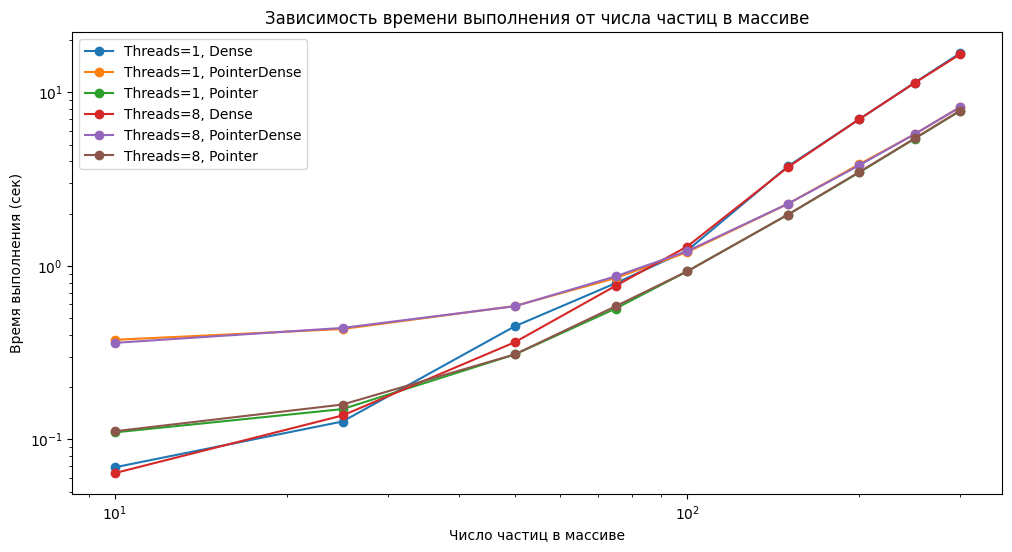

In [87]:
from matplotlib import pyplot as plt

nn = 3
n = 2
N = n * n
i = ((nn + n - 1) // n) - 1
j = N - (i+1) * n

print(i,j)

results = {'Threads=1, seperate': [0.08698487281799316, 0.12722277641296387, 0.28269505500793457, 0.5662872791290283, 0.8995151519775391, 1.9455101490020752, 3.5570788383483887, 5.443428993225098, 7.747436046600342, 10.606478929519653, 17.48893690109253, 22.12200379371643, 31.939817905426025, 43.3469877243042, 56.743489027023315, 72.79400134086609, 89.08467769622803],
         'Threads=1, together': [0.10596513748168945, 0.14902496337890625, 0.3178989887237549, 0.6000101566314697, 0.9234068393707275, 1.9978981018066406, 3.5728039741516113, 5.57355523109436, 7.851873159408569, 10.733845949172974, 17.657039880752563, 22.159754991531372, 31.945471048355103, 43.46283507347107, 57.3130202293396, 72.89983892440796, 89.11812090873718],
         'Threads=8, seperate': [0.08632874488830566, 0.1286461353302002, 0.2974419593811035, 0.5410940647125244, 0.8985412120819092, 1.9343690872192383, 3.546064853668213, 5.400338172912598, 7.782860040664673, 10.522096872329712, 17.45878505706787, 22.0281081199646, 31.749812126159668, 43.761861085891724, 58.53216624259949, 74.03260898590088, 89.70459008216858],
         'Threads=8, together': [0.10655426979064941, 0.1533980369567871, 0.31085801124572754, 0.5793857574462891, 0.9264781475067139, 1.9741039276123047, 3.522550106048584, 5.534543991088867, 7.8047168254852295, 10.641540765762329, 17.687562942504883, 22.244354963302612, 31.910401105880737, 43.53445291519165, 58.04212808609009, 73.46561813354492, 89.30590510368347],
         'Threads=16, seperate': [0.09000515937805176, 0.13260698318481445, 0.28568124771118164, 0.5414588451385498, 0.905433177947998, 1.945511817932129, 3.4786839485168457, 5.37692403793335, 7.935245037078857, 10.622432947158813, 17.692227840423584, 22.310534715652466, 31.82970690727234, 44.125561237335205, 58.69861102104187, 72.9476249217987, 89.44482088088989],
         'Threads=16, together': [0.11928081512451172, 0.15471410751342773, 0.31841516494750977, 0.5665693283081055, 0.9240982532501221, 1.992805004119873, 3.5500500202178955, 5.508656978607178, 7.91858696937561, 10.676705837249756, 17.82328510284424, 22.251245975494385, 31.934037923812866, 43.65330719947815, 57.90269494056702, 72.73848223686218, 89.11072206497192]}

results = {
            'Threads=1, Dense': [0.06369280815124512, 0.0799398422241211, 0.23023700714111328, 0.7255599498748779, 1.1561007499694824, 3.2318408489227295, 6.44382381439209, 10.366543054580688, 15.466341018676758], 
           'Threads=1, PointerDense': [0.06620097160339355, 0.11799311637878418, 0.3216071128845215, 0.8070318698883057, 1.3197848796844482, 3.708216905593872, 6.911919116973877, 11.343498706817627, 16.852789878845215], 
           # 'Threads=1, Pointer': [0.1108100414276123, 0.15069007873535156, 0.30226993560791016, 0.5763161182403564, 0.9561910629272461, 1.9903059005737305, 3.6267802715301514, 5.618380069732666, 8.048715114593506], 
           # 'Threads=8, Dense': [0.0576167106628418, 0.10208392143249512, 0.30400824546813965, 0.6201381683349609, 1.2467679977416992, 3.4358880519866943, 6.661282062530518, 10.53744912147522, 15.390643119812012], 
           # 'Threads=8, PointerDense': [0.06929206848144531, 0.12684988975524902, 0.44897007942199707, 0.7052581310272217, 1.3719818592071533, 3.645678997039795, 7.089694976806641, 11.50041389465332, 16.335751056671143], 
           # # 'Threads=8, Pointer': [0.10810017585754395, 0.15262222290039062, 0.3198990821838379, 0.5674057006835938, 0.9362590312957764, 2.008780002593994, 3.5715548992156982, 5.555742979049683, 7.947805166244507], 
           # 'Threads=16, Dense': [0.06200408935546875, 0.10010099411010742, 0.3241231441497803, 0.6749610900878906, 1.3470749855041504, 3.542512893676758, 6.59389591217041, 10.502833127975464, 15.33068299293518], 
           # 'Threads=16, PointerDense': [0.07744598388671875, 0.12855982780456543, 0.3647167682647705, 0.837777853012085, 1.4269249439239502, 3.5708210468292236, 6.952197074890137, 11.427727222442627, 16.619099855422974], 
           # 'Threads=16, Pointer': [0.11487793922424316, 0.15400409698486328, 0.3248860836029053, 0.574603796005249, 0.9431970119476318, 2.0246691703796387, 3.63633394241333, 5.5734169483184814, 7.9661149978637695]
}
results = {'Threads=1, Dense': [0.06900906562805176, 0.12673497200012207, 0.4485902786254883, 0.794856071472168, 1.22489595413208, 3.7487149238586426, 7.009207010269165, 11.407541990280151, 16.848809003829956], 
           'Threads=1, PointerDense': [0.3748171329498291, 0.43259501457214355, 0.5871927738189697, 0.8508636951446533, 1.1997649669647217, 2.277204990386963, 3.8591089248657227, 5.753485918045044, 8.242521047592163], 
           'Threads=1, Pointer': [0.10969901084899902, 0.1494593620300293, 0.3087329864501953, 0.5675961971282959, 0.9299061298370361, 1.973755121231079, 3.4614949226379395, 5.421097993850708, 7.8333899974823], 
           'Threads=8, Dense': [0.06388592720031738, 0.13730692863464355, 0.36310887336730957, 0.7673239707946777, 1.2923099994659424, 3.70216703414917, 7.0211098194122314, 11.360767841339111, 16.61321711540222], 
           'Threads=8, PointerDense': [0.3600142002105713, 0.43901801109313965, 0.5851778984069824, 0.8702962398529053, 1.2157440185546875, 2.280891180038452, 3.806452989578247, 5.758795976638794, 8.229569673538208], 
           'Threads=8, Pointer': [0.11134004592895508, 0.15876507759094238, 0.30884289741516113, 0.5852606296539307, 0.9295821189880371, 1.9756641387939453, 3.4805288314819336, 5.43550705909729, 7.866428852081299],
           # 'Threads=16, Dense': [0.07164692878723145, 0.13372588157653809, 0.36936402320861816, 0.8185839653015137, 1.2946927547454834, 3.617738962173462, 6.963567018508911, 11.405970811843872, 16.725053071975708],
           # 'Threads=16, PointerDense': [0.4040989875793457, 0.4431271553039551, 0.5839262008666992, 0.8570950031280518, 1.2009961605072021, 2.277106761932373, 3.929561138153076, 5.835641145706177, 8.253154039382935], 
           # 'Threads=16, Pointer': [0.1184089183807373, 0.16138505935668945, 0.3117659091949463, 0.5833070278167725, 0.9359450340270996, 1.9838309288024902, 3.507115125656128, 5.4620139598846436, 7.896637916564941]
           }
plt.figure(figsize=(12, 6))
# par = [10,25,50,75,100,150,200,250,300,350,450,500,600,700,800,900,1000]
par = [10,25,50,75,100,150,200,250,300]
# График времени выполнения
# plt.subplot(1, 2, 1)
for label, times in results.items():
    plt.plot(par, times, label=label, marker='o')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Время выполнения (сек)")
plt.title("Зависимость времени выполнения от числа частиц в массиве")
plt.legend()

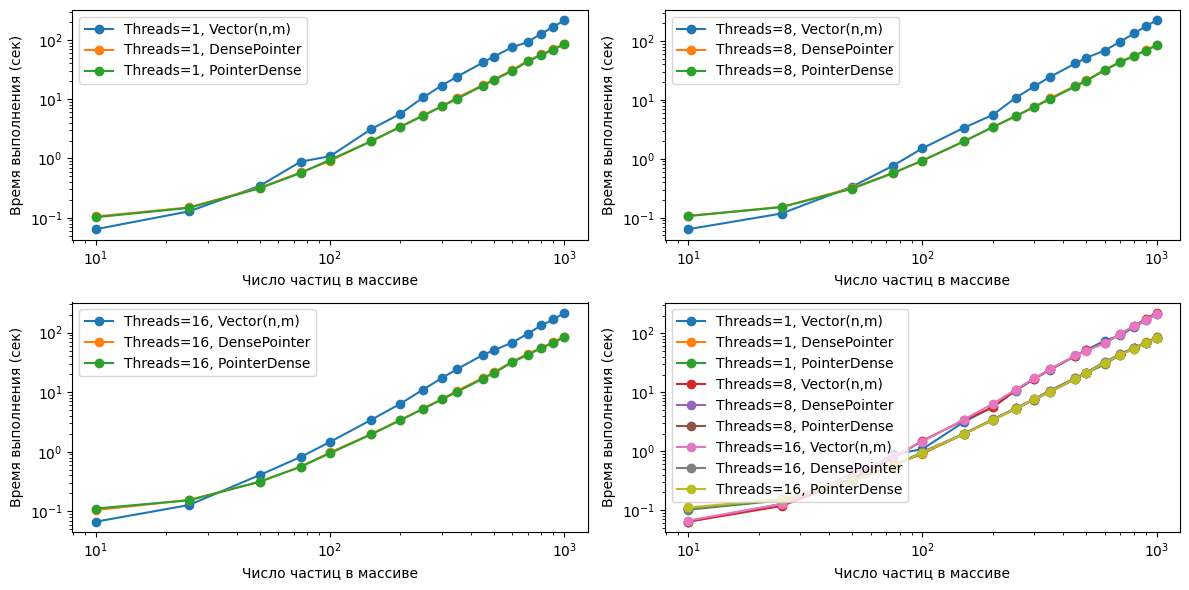

In [96]:
##Vector(n,m) VS DensePointer VS PointerDense 
results = {'Threads=1, Vector(n,m)': [0.06416797637939453, 0.12818098068237305, 0.34296441078186035, 0.8829808235168457, 1.0885040760040283, 3.1251230239868164, 5.677660942077637, 10.684197902679443, 16.956609964370728, 24.037906885147095, 41.51296806335449, 51.990785121917725, 74.8944251537323, 92.03048586845398, 127.49292993545532, 165.57268714904785, 212.4205400943756],
           'Threads=1, DensePointer': [0.1051950454711914, 0.1493818759918213, 0.3200950622558594, 0.5812280178070068, 0.9105758666992188, 1.9643731117248535, 3.43603515625, 5.364262819290161, 7.5777668952941895, 10.623171091079712, 17.286065816879272, 21.366302251815796, 30.86069083213806, 44.56533479690552, 56.905158042907715, 69.95504903793335, 85.39002013206482], 
           'Threads=1, PointerDense': [0.10206413269042969, 0.1470201015472412, 0.3134620189666748, 0.5689482688903809, 0.9471883773803711, 1.9497027397155762, 3.403208017349243, 5.251186847686768, 7.518535852432251, 10.189401149749756, 16.883209943771362, 20.83431315422058, 29.945011854171753, 43.32284998893738, 55.369022846221924, 68.47912096977234, 83.58669209480286], 
           'Threads=8, Vector(n,m)': [0.06392478942871094, 0.11784100532531738, 0.33645009994506836, 0.764857292175293, 1.5065910816192627, 3.3410282135009766, 5.56076192855835, 10.807217121124268, 16.820207118988037, 24.367625951766968, 41.315375089645386, 51.535664319992065, 68.1800627708435, 96.83803391456604, 133.11033987998962, 176.68181824684143, 221.65207290649414],
           'Threads=8, DensePointer': [0.10719084739685059, 0.15259385108947754, 0.3190147876739502, 0.5784988403320312, 0.9274592399597168, 1.9707839488983154, 3.43290376663208, 5.312604188919067, 7.62133002281189, 10.59386920928955, 17.335122108459473, 21.34125590324402, 32.26446008682251, 44.44183707237244, 56.061135053634644, 69.19158673286438, 84.8175196647644], 
           'Threads=8, PointerDense': [0.1069331169128418, 0.15115022659301758, 0.3096179962158203, 0.5718939304351807, 0.9305133819580078, 1.9648499488830566, 3.4583003520965576, 5.261091947555542, 7.5392210483551025, 10.191612243652344, 16.842461109161377, 20.878165006637573, 31.58773398399353, 43.573874950408936, 54.89768195152283, 68.50265908241272, 83.30139422416687],
           'Threads=16, Vector(n,m)': [0.0669407844543457, 0.12754034996032715, 0.4048919677734375, 0.8192851543426514, 1.4605739116668701, 3.438499927520752, 6.4200451374053955, 11.10318636894226, 17.217806100845337, 24.69035577774048, 42.1888267993927, 50.57633876800537, 67.95903396606445, 96.41908979415894, 133.20833206176758, 166.66242694854736, 214.65228295326233], 
           'Threads=16, DensePointer': [0.10489392280578613, 0.15503978729248047, 0.31494712829589844, 0.5616450309753418, 0.975538969039917, 1.9822540283203125, 3.4395062923431396, 5.3201539516448975, 7.617640256881714, 10.656560182571411, 17.40005397796631, 21.456907987594604, 32.76879906654358, 44.0470609664917, 56.09662985801697, 69.70362496376038, 85.2048671245575], 
           'Threads=16, PointerDense': [0.11141490936279297, 0.1531829833984375, 0.31223011016845703, 0.5604772567749023, 0.9429929256439209, 1.9561421871185303, 3.391671895980835, 5.269352912902832, 7.554341793060303, 10.186990737915039, 16.891937971115112, 20.857295274734497, 31.752073049545288, 42.66871762275696, 55.01320672035217, 68.18522071838379, 83.58579206466675]}

par = [10,25,50,75,100,150,200,250,300,350,450,500,600,700,800,900,1000]
plt.figure(figsize=(12, 6))
# par = [10,25,50,75,100,150,200,250,300,350,450,500,600,700,800,900,1000]
# par = [10,25,50,75,100,150,200,250,300]
# График времени выполнения
plt.subplot(2, 2, 1)
for label, times in results.items():
    if "Threads=1," in label:
        plt.plot(par, times, label=label, marker='o')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Время выполнения (сек)")
# plt.title("Зависимость времени выполнения от числа частиц в массиве")
plt.legend()

plt.subplot(2, 2, 2)
for label, times in results.items():
    if "Threads=8," in label:
        plt.plot(par, times, label=label, marker='o')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Время выполнения (сек)")
# plt.title("Зависимость времени выполнения от числа частиц в массиве")
plt.legend()

plt.subplot(2, 2, 3)
for label, times in results.items():
    if "Threads=16," in label:
        plt.plot(par, times, label=label, marker='o')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Время выполнения (сек)")
# plt.title("Зависимость времени выполнения от числа частиц в массиве")
plt.legend()
plt.subplot(2, 2, 4)
for label, times in results.items():
    # if "Threads=16," in label:
    plt.plot(par, times, label=label, marker='o')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Время выполнения (сек)")
# plt.title("Зависимость времени выполнения от числа частиц в массиве")
plt.legend()

plt.tight_layout()
plt.show()

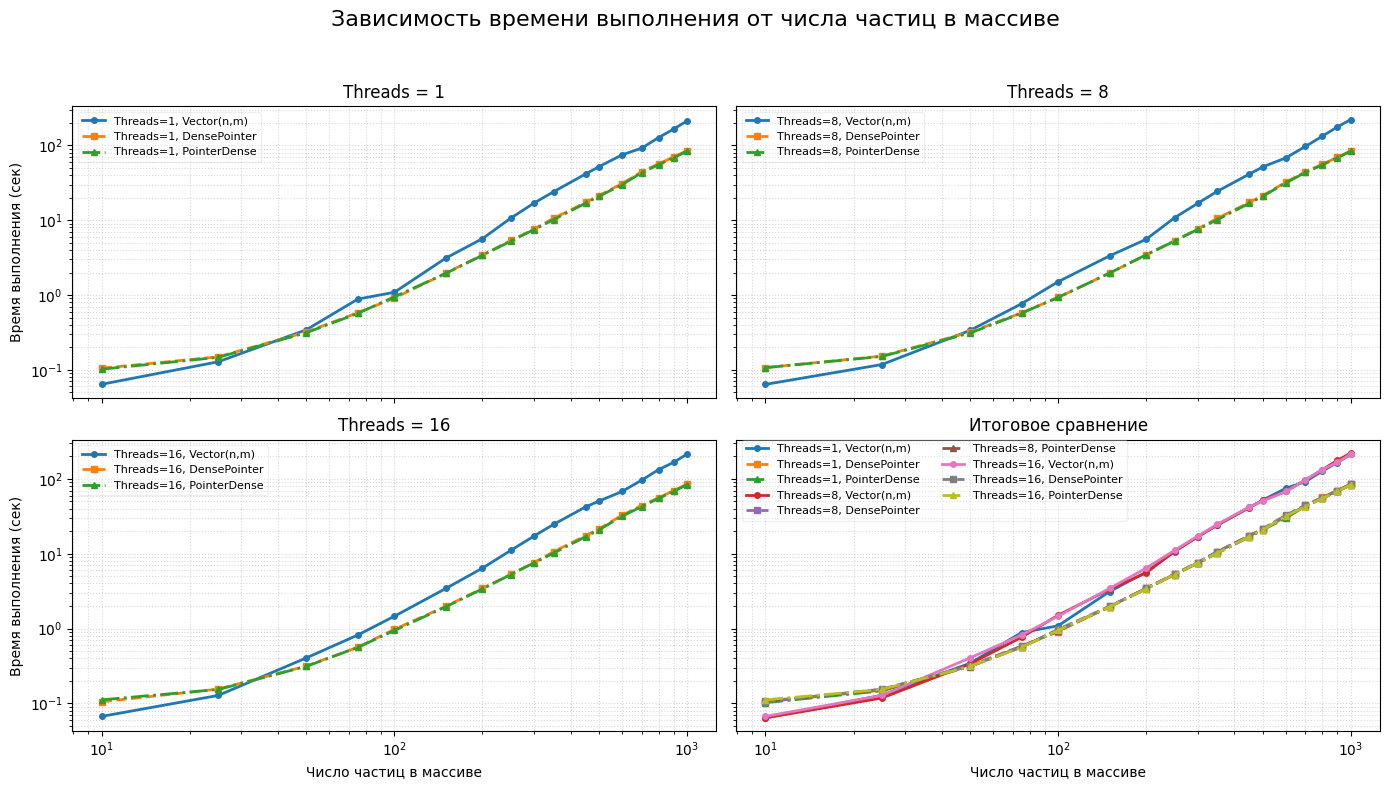

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import re

# ------- 数据 -------
par = [10,25,50,75,100,150,200,250,300,350,450,500,600,700,800,900,1000]
results = {  # 你的原始 results
    'Threads=1, Vector(n,m)': [0.06416797637939453, 0.12818098068237305, 0.34296441078186035, 0.8829808235168457, 1.0885040760040283, 3.1251230239868164, 5.677660942077637, 10.684197902679443, 16.956609964370728, 24.037906885147095, 41.51296806335449, 51.990785121917725, 74.8944251537323, 92.03048586845398, 127.49292993545532, 165.57268714904785, 212.4205400943756],
    'Threads=1, DensePointer': [0.1051950454711914, 0.1493818759918213, 0.3200950622558594, 0.5812280178070068, 0.9105758666992188, 1.9643731117248535, 3.43603515625, 5.364262819290161, 7.5777668952941895, 10.623171091079712, 17.286065816879272, 21.366302251815796, 30.86069083213806, 44.56533479690552, 56.905158042907715, 69.95504903793335, 85.39002013206482],
    'Threads=1, PointerDense': [0.10206413269042969, 0.1470201015472412, 0.3134620189666748, 0.5689482688903809, 0.9471883773803711, 1.9497027397155762, 3.403208017349243, 5.251186847686768, 7.518535852432251, 10.189401149749756, 16.883209943771362, 20.83431315422058, 29.945011854171753, 43.32284998893738, 55.369022846221924, 68.47912096977234, 83.58669209480286],
    'Threads=8, Vector(n,m)': [0.06392478942871094, 0.11784100532531738, 0.33645009994506836, 0.764857292175293, 1.5065910816192627, 3.3410282135009766, 5.56076192855835, 10.807217121124268, 16.820207118988037, 24.367625951766968, 41.315375089645386, 51.535664319992065, 68.1800627708435, 96.83803391456604, 133.11033987998962, 176.68181824684143, 221.65207290649414],
    'Threads=8, DensePointer': [0.10719084739685059, 0.15259385108947754, 0.3190147876739502, 0.5784988403320312, 0.9274592399597168, 1.9707839488983154, 3.43290376663208, 5.312604188919067, 7.62133002281189, 10.59386920928955, 17.335122108459473, 21.34125590324402, 32.26446008682251, 44.44183707237244, 56.061135053634644, 69.19158673286438, 84.8175196647644],
    'Threads=8, PointerDense': [0.1069331169128418, 0.15115022659301758, 0.3096179962158203, 0.5718939304351807, 0.9305133819580078, 1.9648499488830566, 3.4583003520965576, 5.261091947555542, 7.5392210483551025, 10.191612243652344, 16.842461109161377, 20.878165006637573, 31.58773398399353, 43.573874950408936, 54.89768195152283, 68.50265908241272, 83.30139422416687],
    'Threads=16, Vector(n,m)': [0.0669407844543457, 0.12754034996032715, 0.4048919677734375, 0.8192851543426514, 1.4605739116668701, 3.438499927520752, 6.4200451374053955, 11.10318636894226, 17.217806100845337, 24.69035577774048, 42.1888267993927, 50.57633876800537, 67.95903396606445, 96.41908979415894, 133.20833206176758, 166.66242694854736, 214.65228295326233],
    'Threads=16, DensePointer': [0.10489392280578613, 0.15503978729248047, 0.31494712829589844, 0.5616450309753418, 0.975538969039917, 1.9822540283203125, 3.4395062923431396, 5.3201539516448975, 7.617640256881714, 10.656560182571411, 17.40005397796631, 21.456907987594604, 32.76879906654358, 44.0470609664917, 56.09662985801697, 69.70362496376038, 85.2048671245575],
    'Threads=16, PointerDense': [0.11141490936279297, 0.1531829833984375, 0.31223011016845703, 0.5604772567749023, 0.9429929256439209, 1.9561421871185303, 3.391671895980835, 5.269352912902832, 7.554341793060303, 10.186990737915039, 16.891937971115112, 20.857295274734497, 31.752073049545288, 42.66871762275696, 55.01320672035217, 68.18522071838379, 83.58579206466675]
}

# ------- 解析 & 校验 -------
pat = re.compile(r"Threads=(\d+),\s*(.+)")
grouped = {}
for label, times in results.items():
    m = pat.match(label)
    thr = int(m.group(1)); layout = m.group(2)
    arr = np.asarray(times, float)
    assert len(arr) == len(par), f"{label}: {len(arr)} vs len(par)={len(par)}"
    grouped.setdefault(thr, {})[layout] = arr

threads_order = [1, 8, 16]
layouts_order = ["Vector(n,m)", "DensePointer", "PointerDense"]

# 固定样式：同一 layout 在所有子图里样式一致
style = {
    "Vector(n,m)":  dict(marker='o', linestyle='-',  linewidth=2, markersize=4),
    "DensePointer": dict(marker='s', linestyle='--', linewidth=2, markersize=4),
    "PointerDense": dict(marker='^', linestyle='-.', linewidth=2, markersize=4),
}

# ------- 绘图 -------
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
fig.suptitle("Зависимость времени выполнения от числа частиц в массиве", fontsize=16, y=0.98)

# 子图：Threads = 1 / 8 / 16
for ax, thr in zip(axes.flat[:3], threads_order):
    for layout in layouts_order:
        y = grouped[thr][layout]
        ax.plot(par, y, label=f"Threads={thr}, {layout}", **style[layout])
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_title(f"Threads = {thr}", fontsize=12)
    ax.grid(True, which='both', linestyle=':', alpha=0.5)
    # 左列显示 y 轴标签，底行显示 x 轴标签
    if ax in (axes[0,0], axes[1,0]):
        ax.set_ylabel("Время выполнения (сек)")
    if ax in (axes[1,0], axes[1,1]):
        ax.set_xlabel("Число частиц в массиве")
    # 简洁图例
    ax.legend(fontsize=8, loc='upper left', framealpha=0.3)

# 右下角：总览
ax = axes[1,1]
for thr in threads_order:
    for layout in layouts_order:
        ax.plot(par, grouped[thr][layout], label=f"Threads={thr}, {layout}", **style[layout])
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_title("Итоговое сравнение", fontsize=12)
ax.grid(True, which='both', linestyle=':', alpha=0.5)
ax.set_xlabel("Число частиц в массиве")
# 放到外侧，避免遮挡曲线
ax.legend(fontsize=8, ncol=2, loc='upper left', bbox_to_anchor=(0, 1.02), framealpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

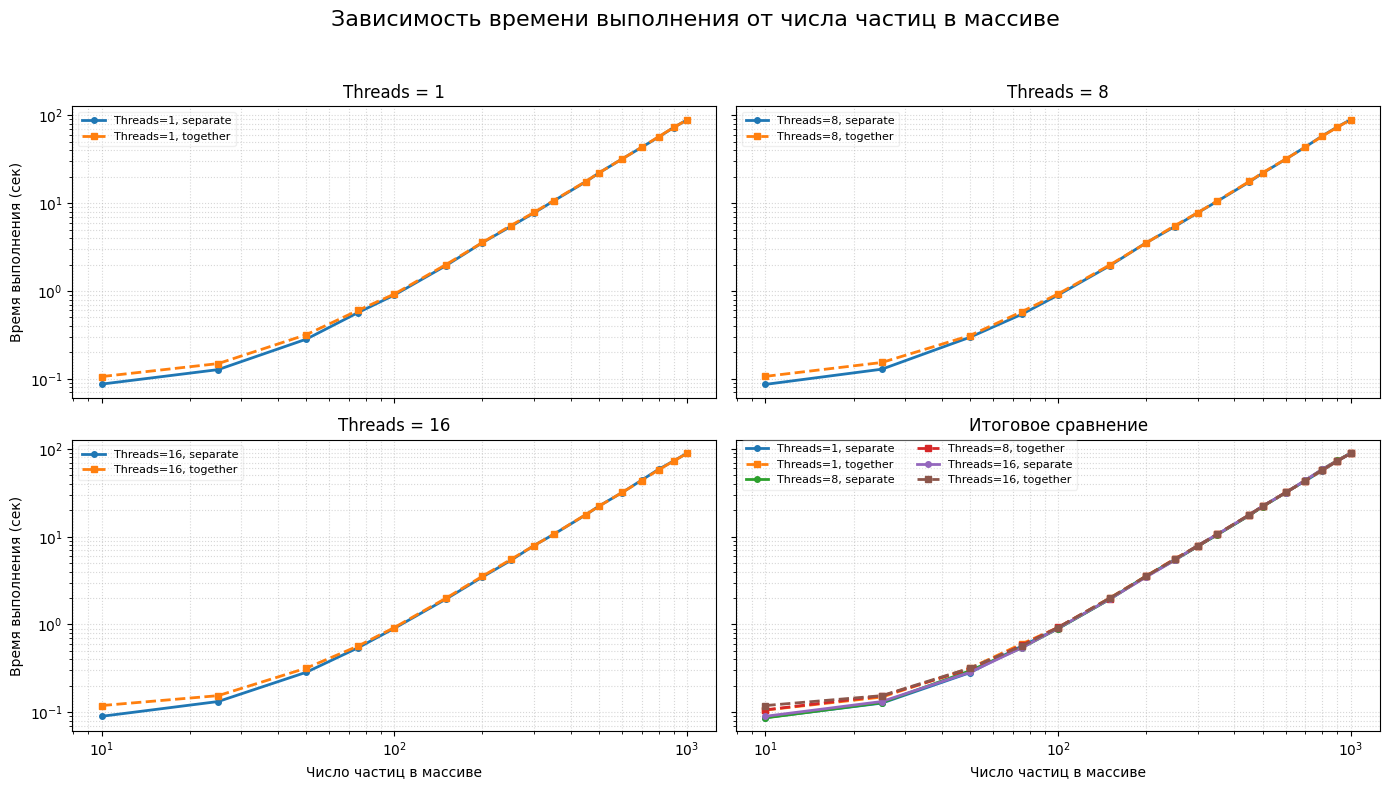

In [105]:
results = {'Threads=1, separate': [0.08698487281799316, 0.12722277641296387, 0.28269505500793457, 0.5662872791290283, 0.8995151519775391, 1.9455101490020752, 3.5570788383483887, 5.443428993225098, 7.747436046600342, 10.606478929519653, 17.48893690109253, 22.12200379371643, 31.939817905426025, 43.3469877243042, 56.743489027023315, 72.79400134086609, 89.08467769622803],
         'Threads=1, together': [0.10596513748168945, 0.14902496337890625, 0.3178989887237549, 0.6000101566314697, 0.9234068393707275, 1.9978981018066406, 3.5728039741516113, 5.57355523109436, 7.851873159408569, 10.733845949172974, 17.657039880752563, 22.159754991531372, 31.945471048355103, 43.46283507347107, 57.3130202293396, 72.89983892440796, 89.11812090873718],
         'Threads=8, separate': [0.08632874488830566, 0.1286461353302002, 0.2974419593811035, 0.5410940647125244, 0.8985412120819092, 1.9343690872192383, 3.546064853668213, 5.400338172912598, 7.782860040664673, 10.522096872329712, 17.45878505706787, 22.0281081199646, 31.749812126159668, 43.761861085891724, 58.53216624259949, 74.03260898590088, 89.70459008216858],
         'Threads=8, together': [0.10655426979064941, 0.1533980369567871, 0.31085801124572754, 0.5793857574462891, 0.9264781475067139, 1.9741039276123047, 3.522550106048584, 5.534543991088867, 7.8047168254852295, 10.641540765762329, 17.687562942504883, 22.244354963302612, 31.910401105880737, 43.53445291519165, 58.04212808609009, 73.46561813354492, 89.30590510368347],
         'Threads=16, separate': [0.09000515937805176, 0.13260698318481445, 0.28568124771118164, 0.5414588451385498, 0.905433177947998, 1.945511817932129, 3.4786839485168457, 5.37692403793335, 7.935245037078857, 10.622432947158813, 17.692227840423584, 22.310534715652466, 31.82970690727234, 44.125561237335205, 58.69861102104187, 72.9476249217987, 89.44482088088989],
         'Threads=16, together': [0.11928081512451172, 0.15471410751342773, 0.31841516494750977, 0.5665693283081055, 0.9240982532501221, 1.992805004119873, 3.5500500202178955, 5.508656978607178, 7.91858696937561, 10.676705837249756, 17.82328510284424, 22.251245975494385, 31.934037923812866, 43.65330719947815, 57.90269494056702, 72.73848223686218, 89.11072206497192]}

# ------- 解析 & 校验 -------
pat = re.compile(r"Threads=(\d+),\s*(.+)")
grouped = {}
for label, times in results.items():
    m = pat.match(label)
    thr = int(m.group(1)); layout = m.group(2)
    arr = np.asarray(times, float)
    assert len(arr) == len(par), f"{label}: {len(arr)} vs len(par)={len(par)}"
    grouped.setdefault(thr, {})[layout] = arr

threads_order = [1, 8, 16]
layouts_order = ["separate", "together"]

# 固定样式：同一 layout 在所有子图里样式一致
style = {
    "separate":  dict(marker='o', linestyle='-',  linewidth=2, markersize=4),
    "together": dict(marker='s', linestyle='--', linewidth=2, markersize=4),
    # "PointerDense": dict(marker='^', linestyle='-.', linewidth=2, markersize=4),
}

# ------- 绘图 -------
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
fig.suptitle("Зависимость времени выполнения от числа частиц в массиве", fontsize=16, y=0.98)

# 子图：Threads = 1 / 8 / 16
for ax, thr in zip(axes.flat[:3], threads_order):
    for layout in layouts_order:
        y = grouped[thr][layout]
        ax.plot(par, y, label=f"Threads={thr}, {layout}", **style[layout])
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_title(f"Threads = {thr}", fontsize=12)
    ax.grid(True, which='both', linestyle=':', alpha=0.5)
    # 左列显示 y 轴标签，底行显示 x 轴标签
    if ax in (axes[0,0], axes[1,0]):
        ax.set_ylabel("Время выполнения (сек)")
    if ax in (axes[1,0], axes[1,1]):
        ax.set_xlabel("Число частиц в массиве")
    # 简洁图例
    ax.legend(fontsize=8, loc='upper left', framealpha=0.3)

# 右下角：总览
ax = axes[1,1]
for thr in threads_order:
    for layout in layouts_order:
        ax.plot(par, grouped[thr][layout], label=f"Threads={thr}, {layout}", **style[layout])
ax.set_xscale("log"); ax.set_yscale("log")
ax.set_title("Итоговое сравнение", fontsize=12)
ax.grid(True, which='both', linestyle=':', alpha=0.5)
ax.set_xlabel("Число частиц в массиве")
# 放到外侧，避免遮挡曲线
ax.legend(fontsize=8, ncol=2, loc='upper left', bbox_to_anchor=(0, 1.02), framealpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

results = {'Threads=1': [], 'Threads=2': [], 'Threads=4': [], 'Threads=6': [], 'Threads=8': [], 'Threads=10': [], 'Threads=12': [], 'Threads=14': [], 'Threads=16': []}
Testing with 10 * 10 particles
Testing with {'cpu_max_num_threads': 1, 'memory_layout': 'dense', 'label': 'Threads=1'} threads
[Taichi] Starting on arch=arm64
results {'Threads=1': [0.07169103622436523], 'Threads=2': [], 'Threads=4': [], 'Threads=6': [], 'Threads=8': [], 'Threads=10': [], 'Threads=12': [], 'Threads=14': [], 'Threads=16': []}
Testing with {'cpu_max_num_threads': 2, 'memory_layout': 'dense', 'label': 'Threads=2'} threads
[Taichi] Starting on arch=arm64
results {'Threads=1': [0.07169103622436523], 'Threads=2': [0.17980003356933594], 'Threads=4': [], 'Threads=6': [], 'Threads=8': [], 'Threads=10': [], 'Threads=12': [], 'Threads=14': [], 'Threads=16': []}
Testing with {'cpu_max_num_threads': 4, 'memory_layout': 'dense', 'label': 'Threads=4'} threads
[Taichi] Starting on arch=arm64
results {'Threads=1': [0.071

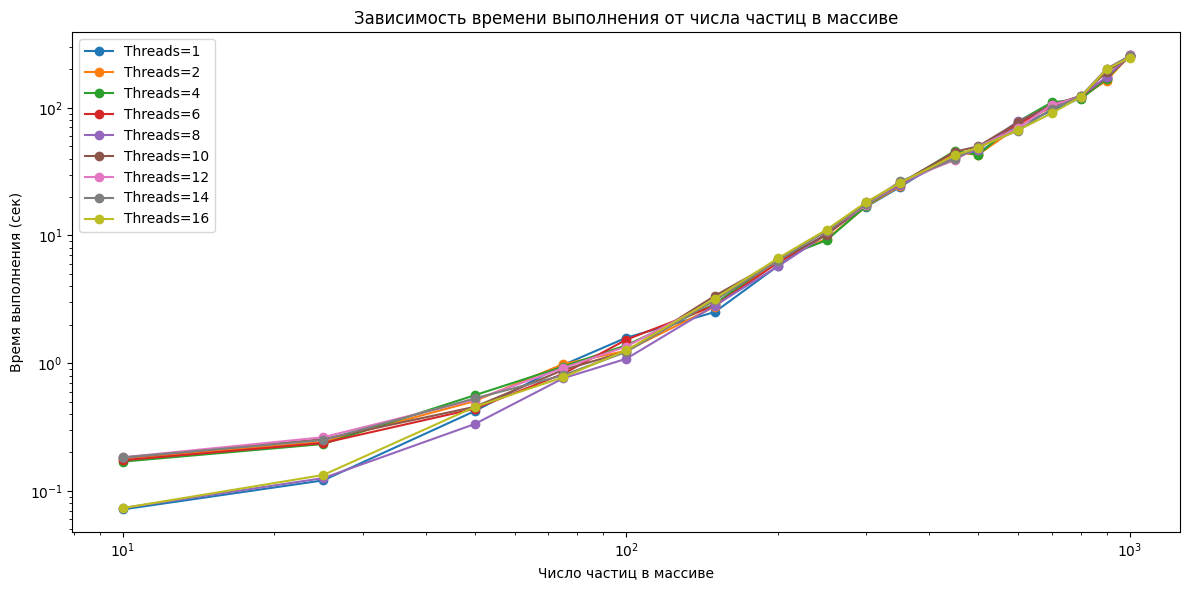

In [107]:
threads_blocks_managment_settings = [
    {"cpu_max_num_threads": 1, "memory_layout": "dense", "label": "Threads=1"},
    {"cpu_max_num_threads": 2, "memory_layout": "dense", "label": "Threads=2"},
    {"cpu_max_num_threads": 4, "memory_layout": "dense", "label": "Threads=4"},
    {"cpu_max_num_threads": 6, "memory_layout": "dense", "label": "Threads=6"},
    {"cpu_max_num_threads": 8, "memory_layout": "dense", "label": "Threads=8"},
    {"cpu_max_num_threads": 10, "memory_layout": "dense", "label": "Threads=10"},
    {"cpu_max_num_threads": 12, "memory_layout": "dense", "label": "Threads=12"},
    {"cpu_max_num_threads": 14, "memory_layout": "dense", "label": "Threads=14"},
    {"cpu_max_num_threads": 16, "memory_layout": "dense", "label": "Threads=16"},
    # {"cpu_max_num_threads": 16, "memory_layout": 64, "label": "Threads=16, Block=64"},
]
# settings = threads_blocks_managment_settings + memory_management_settings
results = {setting["label"]: [] for setting in threads_blocks_managment_settings}
# results["NumPy"] = []
par = [10,25,50,75,100,150,200,250,300,350,450,500,600,700,800,900,1000]
# par = [10,25,50,75,100,150,200,250,300]
# par = [10]
# M = [10,25,50,75,100,150,200]
print(f"{results = }")

for n in par:
    print(f"Testing with {n} * {n} particles")

    # Тестирование Taichi для всех настроек многопоточности
    for setting in threads_blocks_managment_settings:
        print(f"Testing with {setting} threads")
        taichi_time = compute_cpu_memory(
            n,
            n,
            cpu_max_num_threads=setting["cpu_max_num_threads"],
            memory_layout=setting["memory_layout"],
        )
        results[setting["label"]].append(taichi_time)
        print("results", results)

    # # Тестирование Taichi для всех настроек использования памяти
    # for setting in memory_management_settings:
    #     taichi_time = compute_taichi_memory_management(
    #         n,
    #         cpu_max_num_threads=setting["cpu_max_num_threads"],
    #         memory_layout=setting["memory_layout"]
    #     )
    #     results[setting["label"]].append(taichi_time)

# Построение графиков
plt.figure(figsize=(12, 6))

# График времени выполнения
# plt.subplot(1, 2, 1)
for label, times in results.items():
    plt.plot(par, times, label=label, marker='o')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Время выполнения (сек)")
plt.title("Зависимость времени выполнения от числа частиц в массиве")
plt.legend()

# График ускорения относительно NumPy
# plt.subplot(1, 2, 2)
# for label, times in results.items():
#     if label != "NumPy":
#         speedup = [numpy_t / t for numpy_t, t in zip(results["NumPy"], times)]
#         plt.plot(N, speedup, label=label, marker='o')
# plt.xscale("log")
# plt.xlabel("Число частиц в массиве")
# plt.ylabel("Ускорение относительно NumPy)")
# plt.title("Зависимость ускорения от числа частиц в массиве")
# plt.legend()

plt.tight_layout()
plt.show()

results = {'Threads=1': [], 'Threads=2': [], 'Threads=4': [], 'Threads=6': [], 'Threads=8': [], 'Threads=10': [], 'Threads=12': [], 'Threads=14': [], 'Threads=16': []}
Testing with 10 * 10 particles
Testing with {'cpu_max_num_threads': 1, 'memory_layout': 'pointer', 'label': 'Threads=1'} threads
[Taichi] Starting on arch=arm64
results {'Threads=1': [0.0966641902923584], 'Threads=2': [], 'Threads=4': [], 'Threads=6': [], 'Threads=8': [], 'Threads=10': [], 'Threads=12': [], 'Threads=14': [], 'Threads=16': []}
Testing with {'cpu_max_num_threads': 2, 'memory_layout': 'pointer', 'label': 'Threads=2'} threads
[Taichi] Starting on arch=arm64
results {'Threads=1': [0.0966641902923584], 'Threads=2': [0.34354710578918457], 'Threads=4': [], 'Threads=6': [], 'Threads=8': [], 'Threads=10': [], 'Threads=12': [], 'Threads=14': [], 'Threads=16': []}
Testing with {'cpu_max_num_threads': 4, 'memory_layout': 'pointer', 'label': 'Threads=4'} threads
[Taichi] Starting on arch=arm64
results {'Threads=1': [0

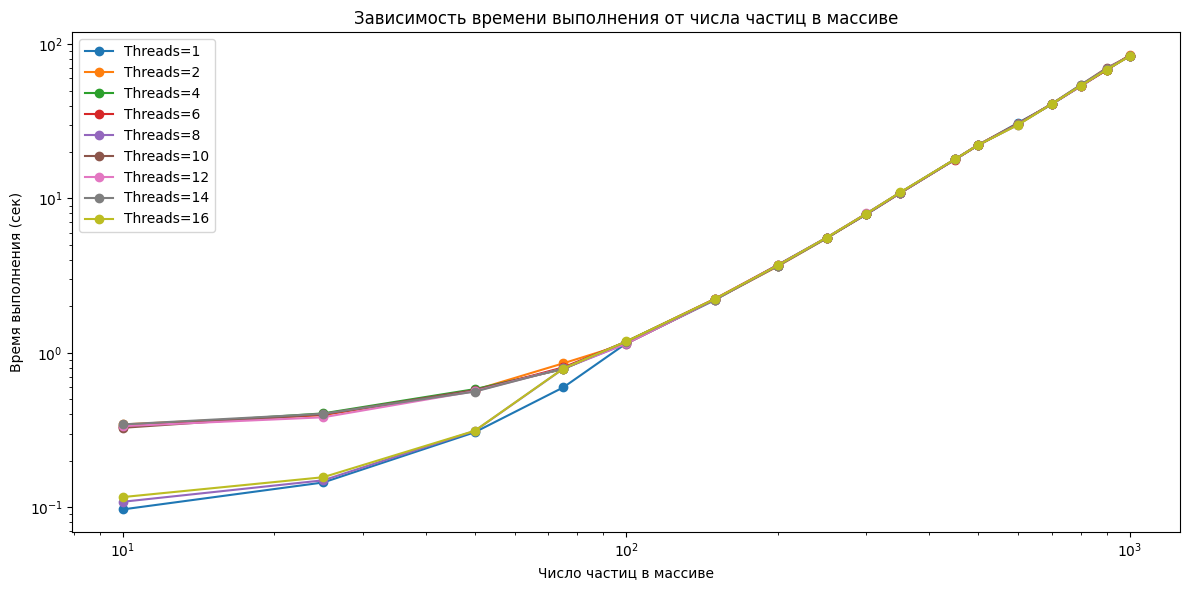

In [108]:
threads_blocks_managment_settings = [
    {"cpu_max_num_threads": 1, "memory_layout": "pointer", "label": "Threads=1"},
    {"cpu_max_num_threads": 2, "memory_layout": "pointer", "label": "Threads=2"},
    {"cpu_max_num_threads": 4, "memory_layout": "pointer", "label": "Threads=4"},
    {"cpu_max_num_threads": 6, "memory_layout": "pointer", "label": "Threads=6"},
    {"cpu_max_num_threads": 8, "memory_layout": "pointer", "label": "Threads=8"},
    {"cpu_max_num_threads": 10, "memory_layout": "pointer", "label": "Threads=10"},
    {"cpu_max_num_threads": 12, "memory_layout": "pointer", "label": "Threads=12"},
    {"cpu_max_num_threads": 14, "memory_layout": "pointer", "label": "Threads=14"},
    {"cpu_max_num_threads": 16, "memory_layout": "pointer", "label": "Threads=16"},
    # {"cpu_max_num_threads": 16, "memory_layout": 64, "label": "Threads=16, Block=64"},
]
# settings = threads_blocks_managment_settings + memory_management_settings
results = {setting["label"]: [] for setting in threads_blocks_managment_settings}
# results["NumPy"] = []
par = [10,25,50,75,100,150,200,250,300,350,450,500,600,700,800,900,1000]
# par = [10,25,50,75,100,150,200,250,300]
# par = [10]
# M = [10,25,50,75,100,150,200]
print(f"{results = }")

for n in par:
    print(f"Testing with {n} * {n} particles")

    # Тестирование Taichi для всех настроек многопоточности
    for setting in threads_blocks_managment_settings:
        print(f"Testing with {setting} threads")
        taichi_time = compute_cpu_memory(
            n,
            n,
            cpu_max_num_threads=setting["cpu_max_num_threads"],
            memory_layout=setting["memory_layout"],
        )
        results[setting["label"]].append(taichi_time)
        print("results", results)

    # # Тестирование Taichi для всех настроек использования памяти
    # for setting in memory_management_settings:
    #     taichi_time = compute_taichi_memory_management(
    #         n,
    #         cpu_max_num_threads=setting["cpu_max_num_threads"],
    #         memory_layout=setting["memory_layout"]
    #     )
    #     results[setting["label"]].append(taichi_time)

# Построение графиков
plt.figure(figsize=(12, 6))

# График времени выполнения
# plt.subplot(1, 2, 1)
for label, times in results.items():
    plt.plot(par, times, label=label, marker='o')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Время выполнения (сек)")
plt.title("Зависимость времени выполнения от числа частиц в массиве")
plt.legend()

# График ускорения относительно NumPy
# plt.subplot(1, 2, 2)
# for label, times in results.items():
#     if label != "NumPy":
#         speedup = [numpy_t / t for numpy_t, t in zip(results["NumPy"], times)]
#         plt.plot(N, speedup, label=label, marker='o')
# plt.xscale("log")
# plt.xlabel("Число частиц в массиве")
# plt.ylabel("Ускорение относительно NumPy)")
# plt.title("Зависимость ускорения от числа частиц в массиве")
# plt.legend()

plt.tight_layout()
plt.show()